# Introductory Tutorial

### The Boltzmann Wealth Model 

**Important:** 
- If you are just exploring Mesa and want the fastest way to execute the code we recommend executing this tutorial online in a Colab notebook. [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/projectmesa/mesa/blob/main/docs/tutorials/intro_tutorial.ipynb) or if you do not have a Google account you can use [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/projectmesa/mesa/main?labpath=docs%2Ftutorials%2Fintro_tutorial.ipynb) (Thas can take 30 seconds to 5 minutes to load)
- If you have installed mesa and are running locally, please ensure that your Mesa version is greater than or equal to 3.0.0b1.

## Tutorial Description

[Mesa](https://github.com/projectmesa/mesa) is a Python framework for [agent-based modeling](https://en.wikipedia.org/wiki/Agent-based_model). This tutorial will assist you in getting started and discover some of the core features of Mesa.  The tutorial starts with the key pieces of a model and then progressively adds functionality. 

Should anyone find any errors, bugs, have a suggestion, or just are looking for clarification, let us know in our [chat](https://matrix.to/#/#project-mesa:matrix.org)!

The premise of this tutorial is to create a starter-level model representing agents exchanging money. 

The table of contents (icon on the left) shows each of the items this tutorial covers with the major sections being: 

- Model Description and Set Up
- Building the Basic Model
- Adding Space
- Collecting Data
- AgentSet Functionality
- Batch Run 

### More Mesa

If you are looking for other Mesa models or tools here are some additional resources. 

- Interactive Dashboard: There is a separate [visualization tutorial](https://mesa.readthedocs.io/latest/tutorials/visualization_tutorial.html) that will take users through building a dashboard for this model (aka Boltzmann Wealth Model).
- Classic ABMs: You can also find canonical examples of ABMs written in Mesa in the [Examples Tab](https://mesa.readthedocs.io/latest/tutorials/examples.html)
- More Examples: Want to integrate Reinforcement Learning or work on the Traveling Salesman Problem checkout  [Mesa Examples](https://github.com/projectmesa/mesa-examples/)
- Mesa-Geo: If you need an ABM with Geographic Information Systems (GIS) checkout [Mesa-Geo](https://mesa-geo.readthedocs.io/latest/)
- Mesa Frames: Have a large complex model that you need to speed up, check out [Mesa Frames](https://github.com/projectmesa/mesa-frames)

## Model Description

This is a simulated agent-based economy. In an agent-based economy, the behavior of an individual economic agent, such as a consumer or producer, is studied in a market environment.
This model is drawn from the field econophysics, specifically a paper prepared by Drăgulescu et al. for additional information on the modeling assumptions used in this model. [Drăgulescu, 2002].

The assumption that govern this model are:

1. There are some number of agents.
2. All agents begin with 1 unit of money.
3. At every step of the model, an agent gives 1 unit of money (if they
   have it) to some other agent.

Even as a starter-level model it yields results that are both interesting and unexpected. 

Due to its simplicity and intrquiging results, we found ti to be a greater starter model. 

### Tutorial Setup

Create and activate a [virtual environment](http://docs.python-guide.org/en/latest/dev/virtualenvs/). *Python version 3.11 or higher is required*.

Install Mesa:

```bash
pip install --upgrade mesa[rec] 
```

If you want to use our newest features, you can also opt to install our latest pre-release version:

```bash
pip install --upgrade --pre mesa[rec]
```

Install Jupyter notebook (optional):

```bash
pip install jupyter
```

Install [Seaborn](https://seaborn.pydata.org/) (which is used for data visualization):

```bash
pip install seaborn
```


**If running in Google Colab run the below cell to install Mesa.** (This will also work in a locally installed version of Jupyter.)

### CHANGE THE NEXT CELL to code if you are in Google COLAB

## Building the Sample Model

After Mesa is installed a model can be built. A jupyter notebook is recommended for this tutorial, this allows for small segments of codes to be examined one at a time. 

### Creating Model With Jupyter notebook

Write the model interactively in [Jupyter](http://jupyter.org/) cells.

Start Jupyter:

```bash
jupyter lab
```

Create a new notebook named `money_model.ipynb` (or whatever you want to call it).

### Creating Model With Script File (IDE, Text Editor, Colab, etc.)

Create a new file called `money_model.py` (or whatever you want to call it)

*Code will be added as the tutorial progresses.*

**Good Practice:** Place a model in its own folder/directory. This is not specifically required for the starter_model, but as other models become more complicated and expand multiple python scripts, documentation, discussions and notebooks may be added.

### Import Dependencies
This includes importing of dependencies needed for the tutorial.

In [209]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

### Create Agent

First create the agent. As the tutorial progresses, more functionality will be added to the agent.

**Background:** Agents are the individual entities that act in the model. Mesa automatically assigns each agent that is created an integer as a `unique_id.` 

**Model-specific information:** Agents are the individuals that exchange money, in this case the amount of money an individual agent has is represented as wealth. 

**Code implementation:** This is done by creating a new class (or object) that extends `mesa.Agent` creating a subclass of  the `Agent` class from mesa. The new class is named `MoneyAgent`. The inherited code of the Mesa agent object can be found in the [mesa repo](https://github.com/projectmesa/mesa/blob/main/mesa/agent.py).

The `MoneyAgent` class is created with the following code:

In [210]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

### Create Model

Next, create the model. This gives us the two basic classes of any Mesa ABM - the agent class (population of agent objects that doing something) and the manager class (a model object that manages the creation, activation, datacollection etc of the agents)

**Background:** The model can be visualized as a list containing all the agents. The model creates, holds and manages all the agent objects, specifically in a dictionary. The model activates agents in discrete time steps.

**Model-specific information:** When a model is created the number of agents within the model is specified. The model then creates the agents and places them in an set of agents. 

**Code implementation:** This is done by creating a new class (or object) that extends `mesa.Model` and calls `super().__init__()`, creating a subclass of the `Model` class from mesa. The new class is named `MoneyModel`.  The technical details about the model object can be found in [model module](https://github.com/projectmesa/mesa/blob/main/mesa/model.py) and the AgentSet in the [agent module](https://github.com/projectmesa/mesa/blob/d7a3834c99a3be809abe2edc8b83610f3d4438ba/mesa/agent.py#L86). A critical point is that you can use the `seed` kwarg (keyword argument) to set a seed which controls the random number generator of the model class allowing for the reproducibility of results. 

The `MoneyModel` class is created with the following code:

In [211]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

### Making the Agents `do`

With the basics of the Agent class and Model class created we can no activate the agents to `do` things

**Background:** Mesa's `do` function calls agent functions the grow your ABM. A step is the smallest unit of time in the model, and is often referred to as a tick. The `do` function and Python functionality can be configured to activate agents in different orders. This can be important as the order in which agents are activated can impact the results of the model [Comer2014]. At each step of the model, one or more of the agents -- usually all of them -- are activated and take their own step, changing internally and/or interacting with one another or the environment.

**Model-specific information:** For this section we will randomly reorder the Agent activation order using  `mesa.Agent.shuffle_do` and have the agents `step` function print the agent unique id they are assigned during the agent creation process. 

**Code implementation:** Using standard ABM convention we add a `step` function to the `MoneyModel` class which calls the `mesa.Agent.shuffle_do` function. We then pass into `shuffle_do` the parameter "step". This tells mesa to look for and execute the `step` function in our MoneyAgent class.  

In [212]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's attribute and set the initial values.
        self.wealth = 1

    def say_hi(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print(f"Hi, I am an agent, you can call me {str(self.unique_id)}.")


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(
            model=self, n=n
        )  # This calls the agent class parameter n number of times

    def step(self):
        """Advance the model by one step."""

        # This function psuedo-randomly reorders the list of agent objects and
        # then iterates through calling the function passed in as the parameter
        self.agents.shuffle_do("say_hi")

### Running the Model
A basic model has now been created. The model can be run by creating a model object and calling the step method. The model will run for one step and print the unique_id of each agent. You may run the model for multiple steps by calling the step method multiple times.

note: If you are using `.py` (script) files instead of `.ipynb` (Jupyter), the common convention is
to have a `run.py` in the same directory as your model code. You then (1) import the ``MoneyModel`` class,
(2) create a model object and (3) run it for a few steps. As shown below:

```python
from money_model import MoneyModel

starter_model = MoneyModel(10)
starter_model.step()
```
Create the model object, and run it for one step:

In [213]:
starter_model = MoneyModel(10)
starter_model.step()

Hi, I am an agent, you can call me 8.
Hi, I am an agent, you can call me 3.
Hi, I am an agent, you can call me 10.
Hi, I am an agent, you can call me 5.
Hi, I am an agent, you can call me 4.
Hi, I am an agent, you can call me 1.
Hi, I am an agent, you can call me 7.
Hi, I am an agent, you can call me 6.
Hi, I am an agent, you can call me 9.
Hi, I am an agent, you can call me 2.


In [214]:
# Run this step a few times and see what happens! notice the order of the agents changes each time.
starter_model.step()

Hi, I am an agent, you can call me 3.
Hi, I am an agent, you can call me 6.
Hi, I am an agent, you can call me 2.
Hi, I am an agent, you can call me 4.
Hi, I am an agent, you can call me 9.
Hi, I am an agent, you can call me 1.
Hi, I am an agent, you can call me 10.
Hi, I am an agent, you can call me 5.
Hi, I am an agent, you can call me 7.
Hi, I am an agent, you can call me 8.


In [215]:
# Challenge: Change the seed from None to a number like 42 and see the impact

In [216]:
# Challenge: Change `shuffle_do` to just `do` and see the impact

### Exercise
Modifying the code below to have every agent print out its `wealth` when it is activated.

In [217]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

    def say_wealth(self):
        # The agent's step will go here.
        # FIXME: need to print the agent's wealth
        print(f"Hi, I am an agent and I am broke!")

Create a model for 12 Agents, and run it for a few steps to see the output.

In [218]:
# Fixme: Create the model object, and run it

### Agents Exchange

Returning back to the MoneyAgent the actual exchange process is now going to be created.

**Background:** This is where the agent's behavior as it relates to each step or tick of the model is defined.

**Model-specific information:** In this case, the agent will check its wealth, and if it has money, give one unit of it away to another random agent.

**Code implementation:** The agent's step method is called by `mesa.Agent.shuffle_do("exchange")`during each step of the model. To allow the agent to choose another agent at random, we use the `model.random` random-number generator. This works just like Python's `random` module, but if a fixed seed set is set when the model is instantiated (see earlier challenge), this allows users to replicate a specific model run later. Once we identify this other agent object we increase their wealth by 1 and decrease this agents wealth by one.

This updates the step function as shown below

In [219]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

    def exchange(self):
        # Verify agent has some wealth
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.agents)
            if other_agent is not None:
                other_agent.wealth += 1
                self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(
            model=self, n=n
        )  # This calls the agent class parameter n number of times

    def step(self):
        """Advance the model by one step."""

        # This function psuedo-randomly reorders the list of agent objects and
        # then iterates through calling the function passed in as the parameter
        self.agents.shuffle_do("exchange")

### Running your first model

With that last piece in hand, it's time for the first rudimentary run of the model.

If you've written the code in its own script file (`money_model.py` or a different name) you can now modify your ``run.py`` or even launch a Jupyter notebook. You then just follow the same three steps of (1) import your model class ``MoneyModel``, (2) create the model object and (3) run it for a few steps. If you wrote the code in one notebook then step 1, importing, is not necessary.

```python
from money_model import MoneyModel
```

now let's create a model with 10 agents, and run it for 30 steps.

In [220]:
model = MoneyModel(10)  # Tells the model to create 10 agents
for _ in range(
    30
):  # Runs the model for 10 steps; an underscore is common convention for a variable that is not used
    model.step()

next, we need to get some data out of the model. Specifically, we want to see the distribution of the agent's wealth. We can get the wealth values with list comprehension, and then use seaborn (or another graphics library) to visualize the data in a histogram.

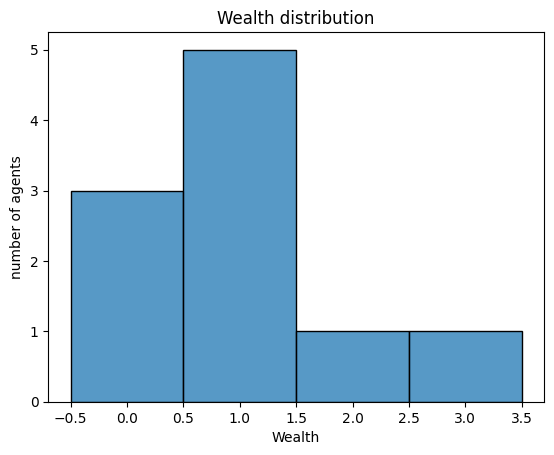

In [221]:
agent_wealth = [a.wealth for a in model.agents]
# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(
    title="Wealth distribution", xlabel="Wealth", ylabel="number of agents"
);  # The semicolon is just to avoid printing the object representation

To get a better idea of how a model behaves, we can create multiple model runs and see the distribution that emerges from all of them. We can do this with a nested for loop:

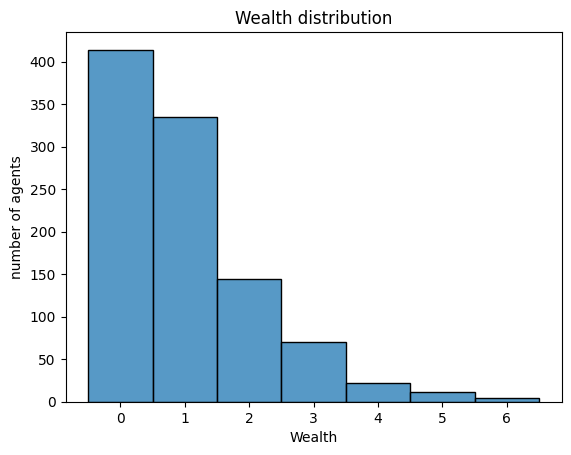

In [222]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for _ in range(100):
    # Run the model
    model = MoneyModel(10)
    for _ in range(30):
        model.step()

    # Store the results
    for agent in model.agents:
        all_wealth.append(agent.wealth)

# Use seaborn
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

This runs 100 instantiations of the model, and runs each for 10 steps. (notice that we set the histogram bins to be integers, since agents can only have whole numbers of wealth). This distribution looks a lot smoother. By running the model 100 times, we smooth out some of the 'noise' of randomness, and get to the model's overall expected behavior.

This outcome might be surprising. Despite the fact that all agents, on average, give and receive one unit of money every step, the model converges to a state where most agents have a small amount of money and a small number have a lot of money.

## Adding space

**Background:** Many ABMs have a spatial element, with agents moving around and interacting with nearby neighbors. Mesa has several types of [spaces](https://mesa.readthedocs.io/latest/apis/space.html) from different types of grids to networks to an in development [cell_space](https://mesa.readthedocs.io/latest/apis/experimental.html#module-experimental.cell_space.__init__). Mesa grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. (Think of grids vs continuous space like the difference between integers and decimals.)

Both grids and continuous spaces are frequently [toroidal](https://en.wikipedia.org/wiki/Toroidal_graph), meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment. You can envision a torous by thinking of donut.

Mesa has two main types of grids: `SingleGrid` and `MultiGrid`. `SingleGrid` enforces at most one agent per cell; `MultiGrid` allows multiple agents to be in the same cell. We are going to use `MultiGrid` and then only exchange money with agents in the same cell.

**Model-specific information:** Let's add a simple spatial element to our model by putting our agents on a grid and make them walk around at random. Instead of giving their unit of money to any random agent, they'll give it to an agent on the same cell. For the Money model multiple agents can be in the same spaces and since they are on a torus the agents on the left side can exchange money with agent on the right. Agents on the top can exchange with agents on the bottom.

**Code Implementation:** We get a random integer within the width and height of the grid space and the use Mesa's multigrid `place_agent` function to place the agent in the specified grid location.

We instantiate a grid with width and height parameters, and a boolean as to whether the grid is toroidal. Let's make width and height model parameters, in addition to the number of agents, and have the grid always be toroidal. We can place agents on a grid with the grid's `place_agent` method, which takes an agent and an (x, y) tuple of the coordinates to place the agent.

In [223]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.randint(0, self.grid.width, size=(n,))
        y = self.rng.randint(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

#### Moving in Mesa

Under the hood, each agent's position is stored in two ways: the agent is contained in the grid in the cell it is currently in, and the agent has a `pos` variable with an (x, y) coordinate tuple. The `place_agent` method adds the coordinate to the agent automatically.

Now we need to add to the agents' behaviors, letting them move around and only give money to other agents in the same cell.

First let's handle movement, and have the agents move to a neighboring cell. The grid object provides a `move_agent` method, which like you'd imagine, moves an agent to a given cell. That still leaves us to get the possible neighboring cells to move to. There are a couple ways to do this. One is to use the current coordinates, and loop over all coordinates +/- 1 away from it. For example:

```python
neighbors = []
x, y = self.pos
for dx in [-1, 0, 1]:
    for dy in [-1, 0, 1]:
        neighbors.append((x+dx, y+dy))
```

But there's an even simpler way, using the grid's built-in `get_neighborhood` method, which returns all the neighbors of a given cell. This method can get two types of cell neighborhoods: [Moore](https://en.wikipedia.org/wiki/Moore_neighborhood) (includes all 8 surrounding squares), and [Von neumann](https://en.wikipedia.org/wiki/Von_neumann_neighborhood)(only up/down/left/right). It also needs an argument as to whether to include the center cell itself as one of the neighbors.

With that in mind, the agent's `move` method looks like this:

```python
class MoneyAgent(mesa.Agent):
   #...
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
```

Next, we need to get all the other agents present in a cell, and give one of them some money. We can get the contents of one or more cells using the grid's `get_cell_list_contents` method, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

```python
class MoneyAgent(mesa.Agent):
    #...
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # Ensure agent is not giving money to itself
        cellmates.pop(
            cellmates.index(self)
        )
        if len(cellmates) > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
```

Now, putting that all together should look like this:

In [224]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # Ensure agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y coordinates for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

Let's create a model with 100 agents on a 10x10 grid, and run it for 20 steps.

In [225]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()

now let's use seaborn and numpy to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros. Then we use the grid object's `coord_iter()` feature, which lets us loop over every cell in the grid, giving us each cell's positions and contents in turn.

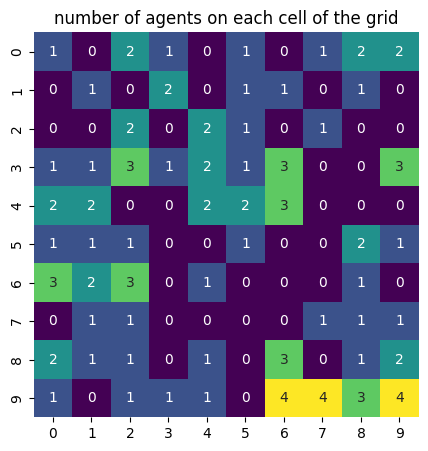

In [226]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="number of agents on each cell of the grid");

In [227]:
# Challenge: Change the size of the grid

In [228]:
# Challenge: Change from multigrid to grid (only one agent per cell)

## Collecting Data

**Background:** So far, at the end of every model run, we've had to go and write our own code to get the data out of the model. This has two problems: it isn't very efficient, and it only gives us end results. If we wanted to know the wealth of each agent at each step, we'd have to add that to the loop of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data: 
 - Model-level variables : Model-level collection functions take a model object as an input. Such as a function that computes a dynamic of the whole model (in this case we will compute a measure of wealth inequality based on all agents wealth)
 - Agent-level variables: Agent-level collection functions take an agent object as an input and is typically the state of an agent attributes, in this case wealth.
 - Tables (which are a catch-all for everything else). 

**Model-specific information:** We will collect two variables to show Mesa capabilities. At the model level, let's measure the model's [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), a measure of wealth inequality. At the agent level, we want to collect every agent's wealth at every step. 

**Code implementation:**
Let's add a DataCollector to the model with [`mesa.DataCollector`](https://github.com/projectmesa/mesa/blob/main/mesa/datacollection.py), and collect the agents wealth and the gini coefficient at each time step. 

In [229]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # Ensure agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height):
        super().__init__()
        self.num_agents = n
        # create the space
        self.grid = mesa.space.MultiGrid(width, height, True)
        # collect the output
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

At every step of the model, the datacollector will collect and store the model-level current Gini coefficient, as well as each agent's wealth, associating each with the current step.

We run the model just as we did above. now is when an interactive session, especially via a notebook, comes in handy: the DataCollector can export the data its collected as a pandas* DataFrame, for easy interactive analysis. 

*If you are new to Python, please be aware that pandas is already installed as a dependency of Mesa and that [pandas](https://pandas.pydata.org/docs/) is a "fast, powerful, flexible and easy to use open source data analysis and manipulation tool". pandas is great resource to help analyze the data collected in your models.

In [230]:
model = MoneyModel(100, 10, 10)
for _ in range(100):
    model.step()

To get the series of Gini coefficients as a pandas DataFrame:

### Visualizing a Model Data

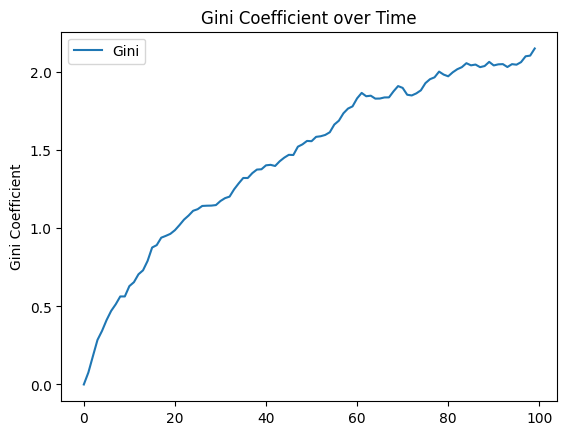

In [231]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

### Visualizing an Agent Data

Similarly, we can get the agent-wealth data:

In [232]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
1    1             1
     2             1
     3             1
     4             1
     5             1

You'll see that the DataFrame's index is pairings of model step and agent ID. This is because the data collector stores the data in a dictionary, with the step number as the key, and a dictionary of agent ID and variable value pairs as the value. The data collector then converts this dictionary into a DataFrame, which is why the index is a pair of (model step, agent ID). You can analyze it the way you would any other DataFrame. For example, to get a histogram of agent wealth at the model's end:

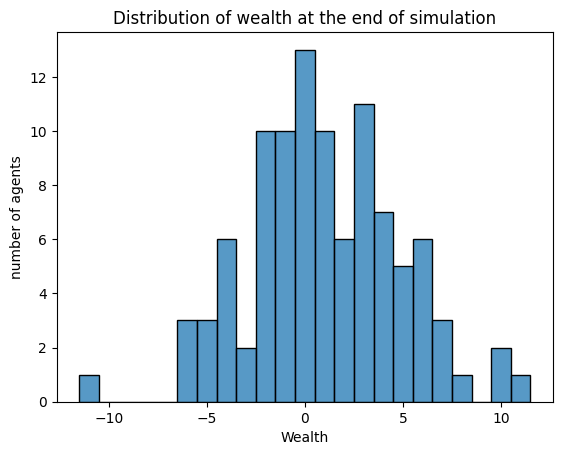

In [233]:
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="number of agents",
);

Or to plot the wealth of a given agent (in this example, agent 7):

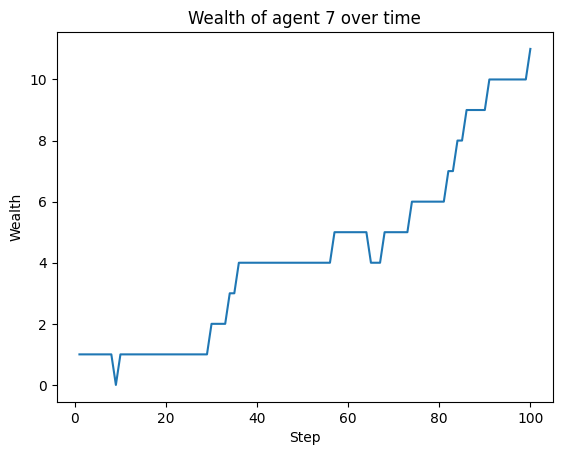

In [234]:
# Get the wealth of agent 7 over time
one_agent_wealth = agent_wealth.xs(7, level="AgentID")

# Plot the wealth of agent 7 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 7 over time");

You can also plot a reporter of multiple agents over time.

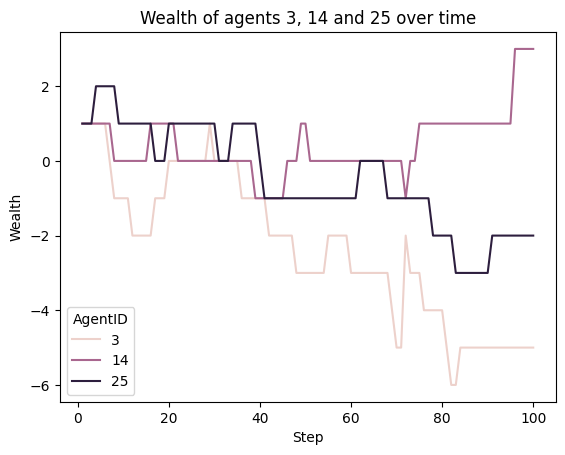

In [235]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

We can also plot the average of all agents, with a 95% confidence interval for that average.

[Text(0.5, 1.0, 'Average wealth over time')]

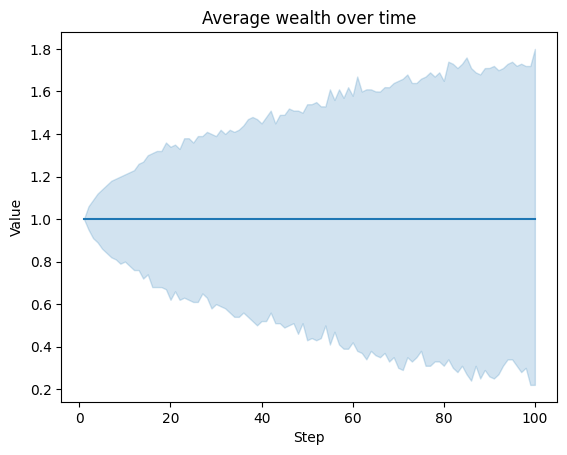

In [236]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

Which is exactly 1, as expected in this model, since each agent starts with one wealth unit, and each agent gives one wealth unit to another agent at each step.

You can also use pandas to export the data to a CSV (comma separated value), which can be opened by any common spreadsheet application or opened by pandas.

If you do not specify a file path, the file will be saved in the local directory. After you run the code below you will see two files appear (*model_data.csv* and *agent_data.csv*)

In [237]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

## AgentSet Functionality

**Background:** With Mesa's AgentSet approach users can also [manage agents](https://mesa.readthedocs.io/latest/overview.html#agentset-and-model-agents) in several ways. 

**Model-specific information:** We will show three agent management techniques just to demonstrate the capability
1. **Applying Methods** We will shuffle the agents and move them and then have them exchange money without reordering them
2. **Selecting** We will institute a policy that has the rich agents give money to the  poor agents
3. **GroupBy** We will group agents together based on wealth

### Applying Methods

**Code Implementation** In this variation we accomplish the same process using the AgentSet features. We remove the step function entirely, shuffle the agent order have them execute the `move` function. Then we have them execute the `give_money` function to get a similar result as we saw in the Adding Space Section. 

In [238]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        if self.wealth > 0:
            cellmates = self.model.grid.get_cell_list_contents([self.pos])
            # Ensure agent is not giving money to itself
            cellmates.pop(cellmates.index(self))
            if len(cellmates) > 0:
                other_agent = self.random.choice(cellmates)
                other_agent.wealth += 1
                self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

Then we set up our model object and run it for 20 steps

In [239]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()

Then we plot our model result on the grid

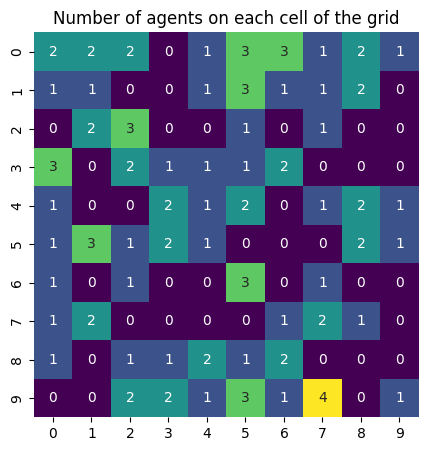

In [240]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

### Selecting 

**Model-specific Information:** For this variation of the model we are going to institute a policy that rich agents give money to poor agent

**Code Implementation:** We will use `agents.select` to separate the agents into rich and poor agents. If there are rich agents then they are the only ones who give money. 

In [241]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def give_money(self, poor_agents):
        if self.wealth > 0:
            other_agent = self.random.choice(poor_agents)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        # Get lists of rich and poor agents
        rich_agents = model.agents.select(lambda a: a.wealth >= 3)
        poor_agents = model.agents.select(lambda a: a.wealth < 3)
        # When there is rich agents only have them give money to the poor agents
        if len(rich_agents) > 0:
            rich_agents.shuffle_do("give_money", poor_agents)
        else:
            poor_agents.shuffle_do("give_money", poor_agents)

We now run the model, collect the data, and plot the results.

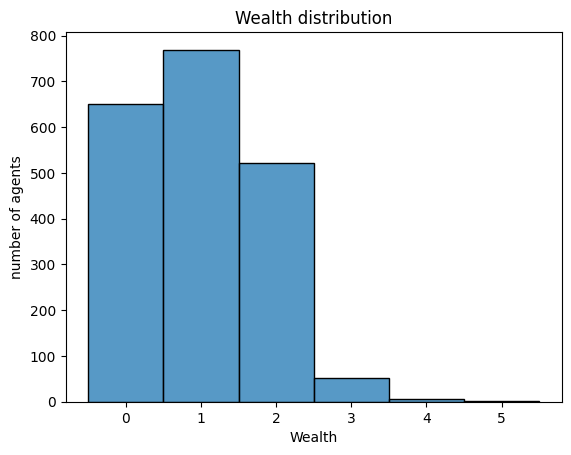

In [242]:
model = MoneyModel(100)
for _ in range(20):
    model.step()


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn
g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

### Group By 

**Model-specific implementation:** In this case we will give agents an attribute of enthnicity of Green, Blue or Mixed. Green and Blue agents only give money to their ethnicity while Mixed can give money to anyone.

**Code Implementation**: Using `groupby` we will execute the above logic in our code passing a list of grouped agents into our `give_money` function.  To ensure we can plot wealth by group we also need to add ethnicity to our datacollector. 

In [243]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, ethnicity):
        super().__init__(model)
        self.wealth = 1
        self.ethnicity = ethnicity

    def give_money(self, similars):
        if self.wealth > 0:
            other_agent = self.random.choice(similars)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create a list of our different ethnicities
        ethnicities = ["Green", "Blue", "Mixed"]

        # Create agents
        MoneyAgent.create_agents(self, n, self.random.choice(ethnicities))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Ethnicity": "ethnicity"},
        )

    def step(self):
        self.datacollector.collect(self)
        # groupby returns a dictionary of the different ethnicities with a list of agents
        grouped_agents = model.agents.groupby("ethnicity")

        for ethnic, similars in grouped_agents:
            if ethnic != "Mixed":
                similars.shuffle_do("give_money", similars)
            else:
                similars.shuffle_do(
                    "give_money", self.agents
                )  # This allows mixed to trade with anyone

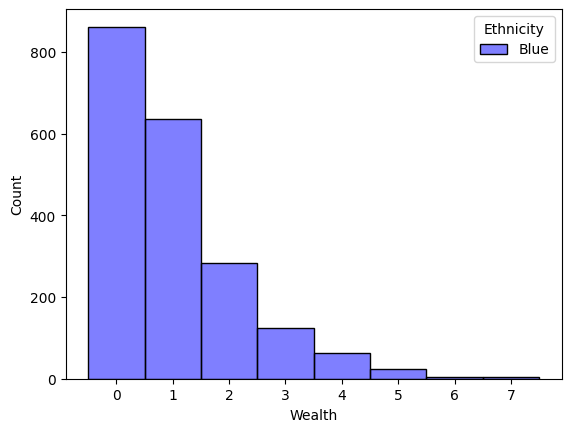

In [244]:
# Run the model
model = MoneyModel(100)
for _ in range(20):
    model.step()

# get the data
data = model.datacollector.get_agent_vars_dataframe()
# assign histogram colors
palette = {"Green": "green", "Blue": "blue", "Mixed": "purple"}
sns.histplot(data=data, x="Wealth", hue="Ethnicity", discrete=True, palette=palette)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

## Batch Run

Like we mentioned above, you usually won't run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model's outputs and behaviors. This is commonly referred to as parameter sweeps. Instead of needing to write nested for-loops for each model, Mesa provides a [`batch_run`](https://github.com/projectmesa/mesa/blob/main/mesa/batchrunner.py) function which automates it for you.

The batch runner also requires an additional variable `self.running` for the MoneyModel class. This variable enables conditional shut off of the model once a condition is met. In this example it will be set as True indefinitely.

#### Additional agent reporter
To make the results a little bit more interesting, we will also calculate the number of consecutive time steps an agent hasn't given any wealth as an agent reporter.

This way we can see how data is handled when multiple reporters are used.

In [245]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.running = True

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"},
        )

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.shuffle_do("give_money")


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0 and self.wealth > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1

#### Batch run parameters

We call `batch_run` with the following arguments:

* `model_cls`
  The model class that is used for the batch run.
* `parameters`
  A dictionary containing all the parameters of the model class and desired values to use for the batch run as key-value pairs. Each value can either be fixed ( e.g. `{"height": 10, "width": 10}`) or an iterable (e.g. `{"n": range(10, 500, 10)}`). `batch_run` will then generate all possible parameter combinations based on this dictionary and run the model `iterations` times for each combination.
* `number_processes`
  If not specified, defaults to 1. Set it to `None` to use all the available processors.
  note: Multiprocessing does make debugging challenging. If your parameter sweeps are resulting in unexpected errors set `number_processes=1`.
* `iterations`
  The number of iterations to run each parameter combination for. Optional. If not specified, defaults to 1.
* `data_collection_period`
  The length of the period (number of steps) after which the model and agent reporters collect data. Optional. If not specified, defaults to -1, i.e. only at the end of each episode.
* `max_steps`
  The maximum number of time steps after which the model halts. An episode does either end when `self.running` of the model class is set to `False` or when `model.steps == max_steps` is reached. Optional. If not specified, defaults to 1000.
* `display_progress`
  Display the batch run progress. Optional. If not specified, defaults to `True`.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the batch runner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps. 

We want to keep track of

1. the Gini coefficient value at each time step, and
2. the individual agent's wealth development and steps without giving money.

**Important:** Since for the latter changes at each time step might be interesting, we set `data_collection_period=1`. By default, it only collects data at the end of each episode.

note: The total number of runs is 245 (= 49 different populations * 5 iterations per population). However, the resulting list of dictionaries will be of length 6186250 (= 250 average agents per population * 49 different populations * 5 iterations per population * 101 steps per iteration). 

**note for Windows OS users:** If you are running this tutorial in Jupyter, make sure that you set `number_processes = 1` (single process). If `number_processes` is greater than 1, it is less straightforward to set up. For details on how to use multiprocessing on windows, see [multiprocessing's programming guidelines](https://docs.python.org/3/library/multiprocessing.html#multiprocessing-programming). 

In [246]:
params = {"width": 10, "height": 10, "n": range(5, 100, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/95 [00:00<?, ?it/s]

To further analyze the return of the `batch_run` function, we convert the list of dictionaries to a Pandas DataFrame and print its keys.

#### Batch Run Analysis and Visualization

In [247]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n', 'Gini', 'AgentID',
       'Wealth', 'Steps_not_given'],
      dtype='object')


First, we want to take a closer look at how the Gini coefficient at the end of each episode changes as we increase the size of the population. For this, we filter our results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode and then scatter-plot the values for the Gini coefficient over the the number of agents. notice there are five values for each population size since we set `iterations=5` when calling the batch run.

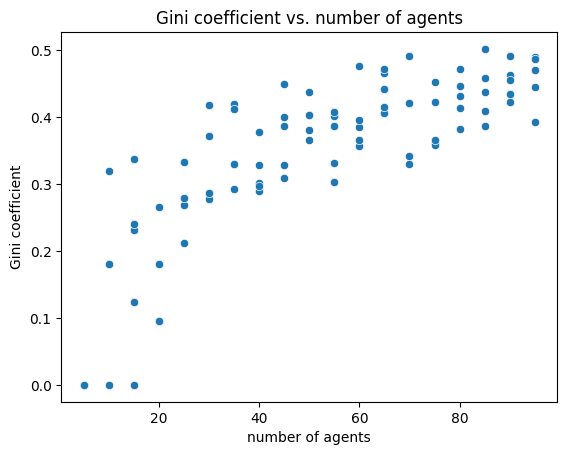

In [248]:
# Filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode
results_filtered = results_df[(results_df.AgentID == 1) & (results_df.Step == 100)]
results_filtered[["iteration", "n", "Gini"]].reset_index(
    drop=True
).head()  # Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="n", y="Gini")
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

We can create different kinds of plot from this filtered DataFrame. For example, a point plot with error bars.

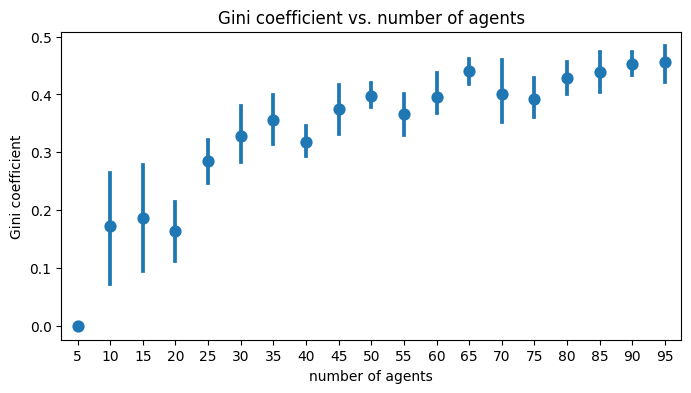

In [249]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x="n", y="Gini", linestyle="None")
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

Second, we want to display the agent's wealth at each time step of one specific episode. To do this, we again filter our large data frame, this time with a fixed number of agents and only for a specific iteration of that population.
To print the results, we convert the filtered data frame to a string specifying the desired columns to print. 

Pandas has built-in functions to convert to a lot of different data formats. For example, to display as a table in a Jupyter notebook, we can use the `to_html()` function which takes the same arguments as `to_string()` (see commented lines).

In [250]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.n == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=10
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter notebook
# from IPython.display import display, HTML
# display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0      NaN     NaN
    1      1.0     1.0
    1      2.0     1.0
    1      3.0     1.0
    1      4.0     1.0
  ...      ...     ...
  100      6.0     1.0
  100      7.0     0.0
  100      8.0     1.0
  100      9.0     1.0
  100     10.0     1.0


Lastly, we want to take a look at the development of the Gini coefficient over the course of one iteration. Filtering and printing looks almost the same as above, only this time we choose a different episode.

In [251]:
results_one_episode = results_df[
    (results_df.n == 10) & (results_df.iteration == 1) & (results_df.AgentID == 1)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=10))

 Step  Gini
    1  0.00
    2  0.00
    3  0.00
    4  0.00
    5  0.00
  ...   ...
   96  0.18
   97  0.18
   98  0.18
   99  0.18
  100  0.18


### Analyzing model reporters: Comparing 5 scenarios
Other insights might be gathered when we compare the Gini coefficient of different scenarios. For example, we can compare the Gini coefficient of a population with 25 agents to the Gini coefficient of a population with 400 agents. While doing this, we increase the number of iterations to 25 to get a better estimate of the Gini coefficient for each population size and get usable error estimations.

As we look varying the parameters to see the impact on model outcomes, it is critical to again point that users can set the random seed. Due to the often inherent randomness with ABMs the seed becomes crucial for: 
- **Reproducibility** - Being able to replicate the ABM results
- **Sensitivity Analysis** - Identifying how sensitive/robust your model results are to random fluctuations

Treating the seed as an additional parameter and running numerous scenarios allows us to see the impact of randomness on this model. 

In [252]:
params = {"seed": None, "width": 10, "height": 10, "n": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=25,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,  # Important, otherwise the datacollector will only collect data of the last time step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

  0%|          | 0/125 [00:00<?, ?it/s]

In [253]:
# Again filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time)
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 1)]
results_5s_df_filtered.head(3)

,RunId,iteration,Step,seed,width,height,n,Gini,AgentID,Wealth,Steps_not_given
1,0,0,1,None,10,10,5,0.0,1.0,1.0,0.0
6,0,0,2,None,10,10,5,0.0,1.0,1.0,1.0
11,0,0,3,None,10,10,5,0.0,1.0,1.0,2.0


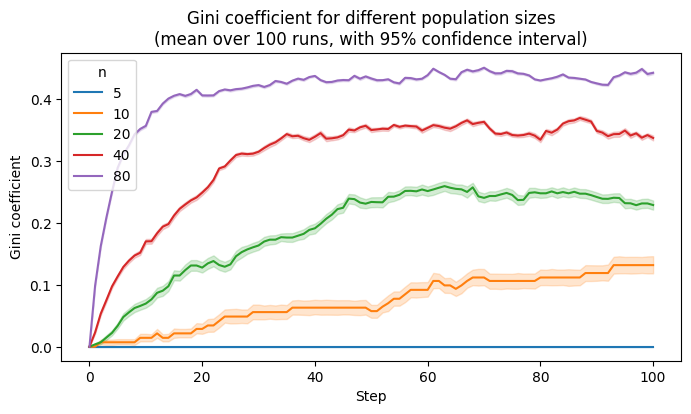

In [254]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="n",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plot_title = "Gini coefficient for different population sizes\n(mean over 100 runs, with 95% confidence interval)"
g.set(title=plot_title, ylabel="Gini coefficient");

In this case it looks like the Gini coefficient increases slower for smaller populations. This can be because of different things, either because the Gini coefficient is a measure of inequality and the smaller the population, the more likely it is that the agents are all in the same wealth class, or because there are less interactions between agents in smaller populations, which means that the wealth of an agent is less likely to change.

In [255]:
# Challenge: Treat the seed as a parameter and see the impact on the Gini Coefficient.
# You can also plot the seeds against the Gini Coefficient by changing the "hue" parameter in sns.lineplot function.

### Analyzing agent reporters: Comparing 5 scenarios
From the agents we collected the wealth and the number of consecutive rounds without a transaction. We can compare the 5 different population sizes by plotting the average number of consecutive rounds without a transaction for each population size.

Note that we're aggregating multiple times here: First we take the average of all agents for each single replication. Then we plot the averages for all replications, with the error band showing the 95% confidence interval of that first average (over all agents). So this error band is representing the uncertainty of the mean value of the number of consecutive rounds without a transaction for each population size.

In [256]:
# Calculate the mean of the wealth and the number of consecutive rounds for all agents in each episode
agg_results_df = (
    results_5s_df.groupby(["iteration", "n", "Step"])
    .agg({"Wealth": "mean", "Steps_not_given": "mean"})
    .reset_index()
)
agg_results_df.head(3)

,iteration,n,Step,Wealth,Steps_not_given
0,0,5,0,NaN,NaN
1,0,5,1,1.0,0.0
2,0,5,2,1.0,1.0


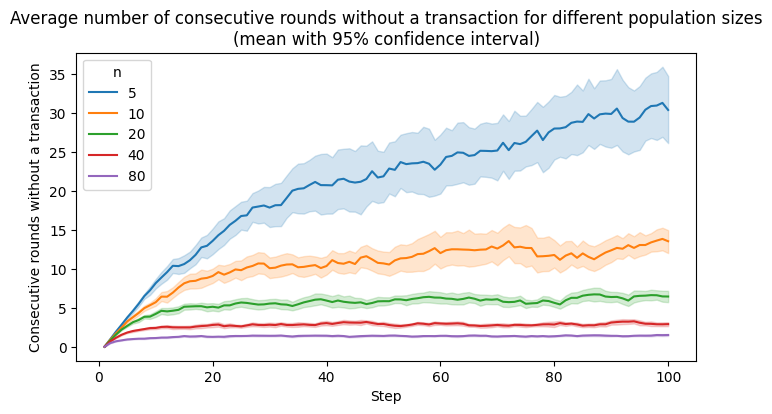

In [257]:
# Create a line plot with error bars
g = sns.lineplot(
    data=agg_results_df, x="Step", y="Steps_not_given", hue="n", palette="tab10"
)
g.figure.set_size_inches(8, 4)
g.set(
    title="Average number of consecutive rounds without a transaction for different population sizes\n(mean with 95% confidence interval)",
    ylabel="Consecutive rounds without a transaction",
);

It can be clearly seen that the lower the number of agents, the higher the number of consecutive rounds without a transaction. This is because the agents have fewer interactions with each other and therefore the wealth of an agent is less likely to change.

### General steps for analyzing results

Many other analysis are possible based on the policies, scenarios and uncertainties that you might be interested in. In general, you can follow these steps to do your own analysis:

1. Determine which metrics you want to analyse. Add these as model and agent reporters to the datacollector of your model.
2. Determine the input parameters you want to vary. Add these as parameters to the batch_run function, using ranges or lists to test different values.
3. Determine the hyperparameters of the batch_run function. Define the number of iterations, the number of processes, the number of steps, the data collection period, etc.
4. Run the batch_run function and save the results.
5. Transform, filter and aggregate the results to get the data you want to analyze. Make sure it's in long format, so that each row represents a single value.
6. Choose a plot type, what to plot on the x and y axis, which columns to use for the hue. Seaborn also has an amazing [Example Gallery](https://seaborn.pydata.org/examples/index.html).
7. Plot the data and analyze the results.

In [258]:
# Challenge update the model, conduct a batch run with a parameter sweep, and visualize your results

## Next Steps

Check out the [visualization tutorial](https://mesa.readthedocs.io/latest/tutorials/visualization_tutorial.html) on how to build interactive dashboards for your models.

## Happy Modeling!

This document is a work in progress.  If you see any errors, exclusions or have any problems please contact [us](https://github.com/projectmesa/mesa/issues).

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.